In [1]:
cd ../

c:\Users\eduar\Documents\usp\AMST\ml_timeseries_usp


In [16]:
from utils import (
    read_all_csv_files,
    correcting_dtypes,
    stocks_removing_negatives,
    remove_materials_no_sales,
    plot_time_series_by_products,
    plot_products_materials,
    plot_produtos_in_cds,
    plot_time_series_cds_products_by_stores,
    plot_time_series_cds_products_by_store_size,
    plot_time_series_cds_products_by_store_weather,
    plot_time_series_cds_products_by_store_profile,
    plot_time_series_cds_products_store_region,
    violin_plot_material_store_sales,
    hierarchical_aggregation,
    remove_time_series_min_length
    )
import pandas as pd
import seaborn as sns
from statsforecast import StatsForecast
from statsforecast.models import MSTL,AutoETS,AutoARIMA
from hierarchicalforecast.methods import BottomUp
from statsmodels.graphics.tsaplots import plot_acf
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import evaluate
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss
from functools import partial
from prophet import Prophet
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [3]:
#data preparation
df = read_all_csv_files()
df = correcting_dtypes(df)
df = stocks_removing_negatives(df)
df = remove_materials_no_sales(df)
df = remove_time_series_min_length(df, min_length=24)

In [4]:
spec = [
        ['total'],
        ['total','centro_distribuicao'],
        #['total','centro_distribuicao','regiao_loja'],
        #['total','centro_distribuicao','regiao_loja','clima_loja'],
        #['total','centro_distribuicao','regiao_loja','clima_loja','loja'],
        #['total','centro_distribuicao','regiao_loja','clima_loja','loja','produto'],
        #['total','centro_distribuicao','regiao_loja','clima_loja','loja','produto','material'],
        #['total','centro_distribuicao','regiao_loja','clima_loja','loja','produto','material','sku']
]

Y_df, S_df, tags = hierarchical_aggregation(df, spec, columns = ['centro_distribuicao','regiao_loja','clima_loja','loja','produto','material','sku','mes','venda_unidades'], ds='mes', y='venda_unidades')

Níveis criados:
total: 1 séries
total/centro_distribuicao: 3 séries


In [5]:
def train_test_split(Y_df,h=6):
    Y_test_df  = Y_df.groupby('unique_id').tail(h)
    Y_train_df = Y_df.drop(Y_test_df.index)
    return Y_test_df, Y_train_df

In [6]:
def gerar_holidays():
    holidays_data = {
    'holiday': [
        # 2023
        'Dia_da_Mulher', 'Carnaval', 'Natal', 'Ano_Novo', 'Black_Friday', 'Cyber_Monday',
        # 2024
        'Dia_da_Mulher', 'Carnaval', 'Natal', 'Ano_Novo', 'Black_Friday', 'Cyber_Monday',
        # 2025
        'Dia_da_Mulher', 'Carnaval', 'Natal', 'Ano_Novo', 'Black_Friday', 'Cyber_Monday'
    ],
    'ds': pd.to_datetime([
        # 2023
        '2023-03-08', '2023-02-20', '2023-12-25', '2023-12-31', '2023-11-24', '2023-11-27',
        # 2024
        '2024-03-08', '2024-02-12', '2024-12-25', '2024-12-31', '2024-11-29', '2024-12-02',
        # 2025
        '2025-03-08', '2025-03-03', '2025-12-25', '2025-12-31', '2025-11-28', '2025-12-01'
    ]),
    'lower_window': [-1] * 18,
    'upper_window': [1] * 18
}

    holidays_df = pd.DataFrame(holidays_data)
    return holidays_df

In [7]:
def prever_individual(Y_df,tag,plot=False):
    Y_df = Y_df[Y_df['unique_id']==tag]
    Y_test_df, Y_train_df = train_test_split(Y_df,h=6)

    model = Prophet(yearly_seasonality=6, daily_seasonality=False, weekly_seasonality=False,holidays=gerar_holidays())
    model.fit(Y_train_df)
    future = model.make_future_dataframe(periods=6, freq='MS')
    forecast = model.predict(future)
    if plot:
        model.plot_components(forecast)
        model.plot(forecast)
    df_fitted = forecast[['ds', 'yhat']].iloc[:-6].merge(Y_train_df,on='ds')[['unique_id','ds','y','yhat']].rename(columns={'yhat':'Prophet'})
    df_yhat = forecast[['ds', 'yhat']].iloc[-6:].merge(Y_test_df,on='ds')[['unique_id','ds','y','yhat']].rename(columns={'yhat':'Prophet'})
    print(smape(df_yhat,models=['Prophet'],id_col='unique_id', target_col='y'))
    return df_fitted, df_yhat

  unique_id   Prophet
0     total  0.217933


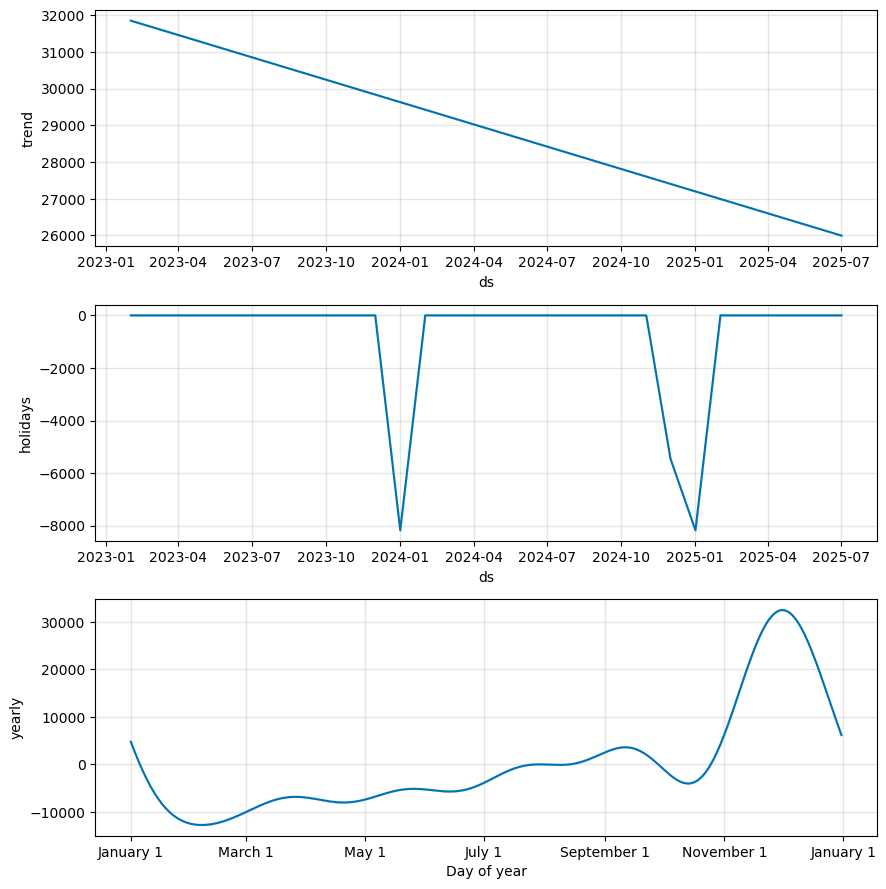

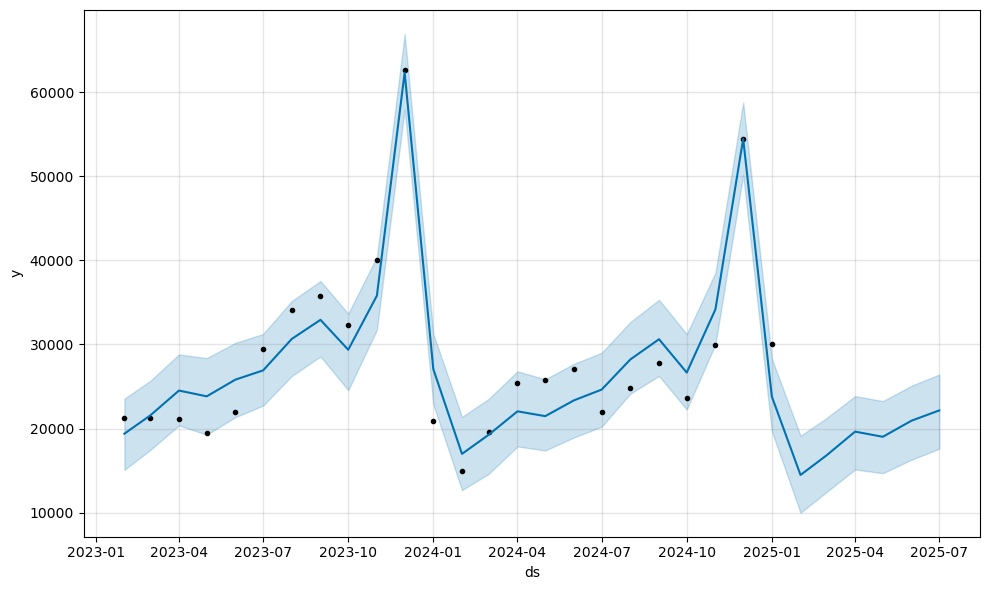

In [276]:
df_fitted, df_yhat = prever_individual(Y_df,'total',plot=True)

<Axes: title={'center': 'Forecast vs Actuals for total'}, xlabel='ds'>

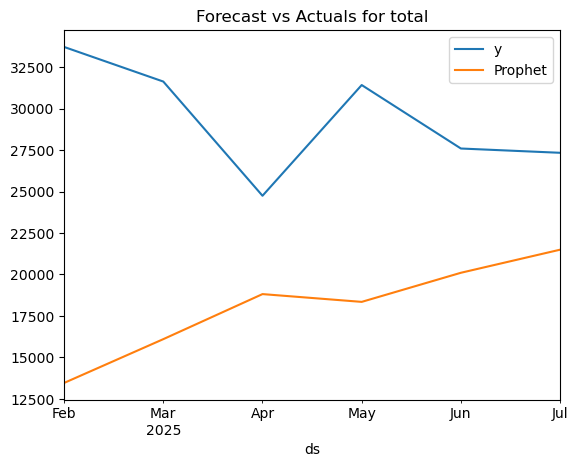

In [231]:
df_yhat.plot(x='ds', y=['y', 'Prophet'], kind='line', title='Forecast vs Actuals for total')

In [8]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.setLevel(logging.WARNING)

In [13]:
def model_tuning(df,initial,horizon):
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'holidays_prior_scale': [0.01,0.1,1.0, 10.0],
        'seasonality_mode':['additive', 'multiplicative'],
        'changepoint_range':[0.8, 0.95]
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params,yearly_seasonality=6,daily_seasonality=False,weekly_seasonality=False,holidays=gerar_holidays()).fit(df)  # Fit model with given params
        df_cv = cross_validation(m,initial=initial, horizon=horizon, parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].mean())

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    print(tuning_results)
    best_params = all_params[np.argmin(rmses)]
    print(best_params)
    return best_params

In [17]:
def prever_individual_cv(Y_df,tag='total',plot=True):
    Y_df = Y_df[Y_df['unique_id']==tag]
    Y_test_df, Y_train_df = train_test_split(Y_df,h=6)
    best_params = model_tuning(Y_train_df,initial = pd.to_timedelta(30*6,unit="D"), horizon = pd.to_timedelta(30*6,unit="D"))
    model = Prophet(**best_params,yearly_seasonality=6,daily_seasonality=False,weekly_seasonality=False)
    model.fit(Y_train_df)
    future = model.make_future_dataframe(periods=6, freq='MS')
    forecast = model.predict(future)
    if plot:
        model.plot_components(forecast)
        model.plot(forecast)
    df_fitted = forecast[['ds', 'yhat']].iloc[:-6].merge(Y_train_df,on='ds')[['unique_id','ds','y','yhat']].rename(columns={'yhat':'Prophet'})
    df_yhat = forecast[['ds', 'yhat']].iloc[-6:].merge(Y_test_df,on='ds')[['unique_id','ds','y','yhat']].rename(columns={'yhat':'Prophet'})
    print(smape(df_yhat,models=['Prophet'],id_col='unique_id', target_col='y'))
    return df_fitted, df_yhat

In [ ]:
df_fitted, df_yhat = prever_individual_cv(Y_df)

00:58:32 - cmdstanpy - INFO - Chain [1] start processing
00:58:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
00:58:35 - cmdstanpy - INFO - Chain [1] start processing
00:58:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
00:58:38 - cmdstanpy - INFO - Chain [1] start processing
00:58:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
00:58:41 - cmdstanpy - INFO - Chain [1] start processing
00:58:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
00:58:44 - cmdstanpy - INFO - Chain [1] start processing
00:58:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has per

<Axes: title={'center': 'Forecast vs Actuals for total'}, xlabel='ds'>

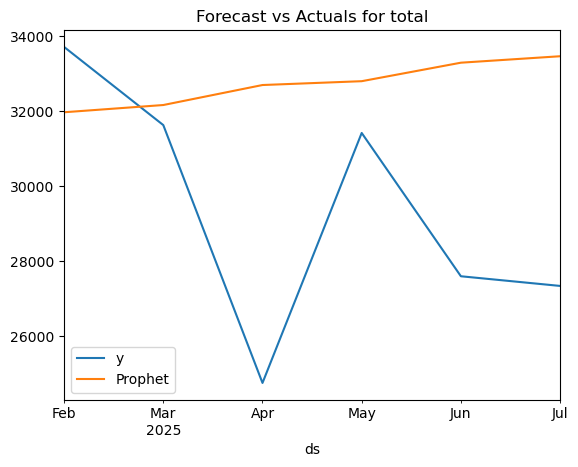

In [ ]:
df_yhat.plot(x='ds', y=['y', 'Prophet'], kind='line', title='Forecast vs Actuals for total')

In [102]:
future.iloc[-6:]

,ds
24,2025-02-01
25,2025-03-01
26,2025-04-01
27,2025-05-01
28,2025-06-01
29,2025-07-01


In [103]:
Y_test_df[Y_test_df['unique_id']=='total']

,unique_id,ds,y
24,total,2025-02-01,33718.0
25,total,2025-03-01,31631.0
26,total,2025-04-01,24745.0
27,total,2025-05-01,31421.0
28,total,2025-06-01,27594.0
29,total,2025-07-01,27336.0


In [98]:
Y_train_df[Y_train_df['unique_id']=='total']

,unique_id,ds,y
0,total,2023-02-01,21312.0
1,total,2023-03-01,21305.0
2,total,2023-04-01,21149.0
3,total,2023-05-01,19518.0
4,total,2023-06-01,22027.0
5,total,2023-07-01,29457.0
6,total,2023-08-01,34111.0
7,total,2023-09-01,35704.0
8,total,2023-10-01,32344.0
9,total,2023-11-01,40077.0


In [91]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-02-01,25119.762045,12287.484053,38361.420350,25119.762045,25119.762045,0.0,0.0,0.0,0.0,0.0,0.0,25119.762045
1,2023-03-01,25397.237665,12753.811027,39598.351058,25397.237665,25397.237665,0.0,0.0,0.0,0.0,0.0,0.0,25397.237665
2,2023-04-01,25704.442817,12776.429410,39595.624081,25704.442817,25704.442817,0.0,0.0,0.0,0.0,0.0,0.0,25704.442817
3,2023-05-01,26001.738128,12067.992713,39398.536917,26001.738128,26001.738128,0.0,0.0,0.0,0.0,0.0,0.0,26001.738128
4,2023-06-01,26308.943279,13326.113670,39894.610848,26308.943279,26308.943279,0.0,0.0,0.0,0.0,0.0,0.0,26308.943279
5,2023-07-01,26606.238586,13140.957482,39231.429930,26606.238586,26606.238586,0.0,0.0,0.0,0.0,0.0,0.0,26606.238586
6,2023-08-01,26913.443741,13376.575266,40428.615336,26913.443741,26913.443741,0.0,0.0,0.0,0.0,0.0,0.0,26913.443741
7,2023-09-01,27220.648893,14719.398506,41510.709400,27220.648893,27220.648893,0.0,0.0,0.0,0.0,0.0,0.0,27220.648893
8,2023-10-01,27517.944202,14068.645362,40767.531985,27517.944202,27517.944202,0.0,0.0,0.0,0.0,0.0,0.0,27517.944202
9,2023-11-01,27825.149353,14157.387870,41248.262603,27825.149353,27825.149353,0.0,0.0,0.0,0.0,0.0,0.0,27825.149353


In [67]:
Y_test_df

,unique_id,ds,y
24,total,2025-02-01,33718.0
25,total,2025-03-01,31631.0
26,total,2025-04-01,24745.0
27,total,2025-05-01,31421.0
28,total,2025-06-01,27594.0
29,total,2025-07-01,27336.0
54,total/CD1,2025-02-01,6124.0
55,total/CD1,2025-03-01,5140.0
56,total/CD1,2025-04-01,5143.0
57,total/CD1,2025-05-01,7536.0


In [ ]:
def prever_individual_cd(Y_df, initial='730 days', period='180 days', horizon = '365 days'):
    df_cv = cross_validation(Y_df, initial = pd.to_timedelta(30*12,unit="D"), horizon = pd.to_timedelta(30*12,unit="D"))


In [59]:
Y_test_df  = Y_df.groupby('unique_id').tail(6)
Y_train_df = Y_df.drop(Y_test_df.index)

In [46]:
from prophet import Prophet

In [55]:
models = [Prophet()]

In [59]:
from mlforecast import MLForecast

In [64]:
mf = MLForecast(models=[Prophet()], freq="MS",num_threads=4)

In [56]:
sf = StatsForecast(models=models, freq="MS", n_jobs=-1)

In [57]:
StatsForecast?

Init signature:
StatsForecast(
    models: List[Any],
    freq: Union[str, int],
    n_jobs: int = 1,
    fallback_model: Optional[Any] = None,
    verbose: bool = False,
)
Docstring:     
The `StatsForecast` class allows you to efficiently fit multiple `StatsForecast` models
for large sets of time series. It operates on a DataFrame `df` with at least three columns
ids, times and targets.

The class has memory-efficient `StatsForecast.forecast` method that avoids storing partial
model outputs. While the `StatsForecast.fit` and `StatsForecast.predict` methods with
Scikit-learn interface store the fitted models.

The `StatsForecast` class offers parallelization utilities with Dask, Spark and Ray back-ends.
See distributed computing example [here](https://github.com/Nixtla/statsforecast/tree/main/experiments/ray).
Init docstring:
Train statistical models.

Parameters
----------
models : List[Any]
    List of instantiated objects models.StatsForecast.
freq : str or int
    Frequency of the

In [243]:
sf.cross_validation?

Signature:
sf.cross_validation(
    h: int,
    df: Any,
    n_windows: int = 1,
    step_size: int = 1,
    test_size: Optional[int] = None,
    input_size: Optional[int] = None,
    level: Optional[List[int]] = None,
    fitted: bool = False,
    refit: Union[bool, int] = True,
    prediction_intervals: Optional[statsforecast.utils.ConformalIntervals] = None,
    id_col: str = 'unique_id',
    time_col: str = 'ds',
    target_col: str = 'y',
)
Docstring:
Temporal Cross-Validation.

Efficiently fits a list of `StatsForecast`
models through multiple training windows, in either chained or rolled manner.

`StatsForecast.models`' speed allows to overcome this evaluation technique
high computational costs. Temporal cross-validation provides better model's
generalization measurements by increasing the test's length and diversity.

Parameters
----------
h : int
    Forecast horizon.
df : pandas or polars DataFrame
    DataFrame with ids, times, targets and exogenous.
n_windows : int (default

In [54]:
cv_df = sf.cross_validation(df = Y_train_df,
    h = 6,
    step_size = 3,
    n_windows = 6,
    id_col = 'unique_id')

AttributeError: 'Prophet' object has no attribute 'forecast'

In [52]:
sf.forecast?

Signature:
sf.forecast(
    h: int,
    df: Any,
    X_df: Union[pandas.core.frame.DataFrame, utilsforecast.compat.pl_DataFrame, NoneType] = None,
    level: Optional[List[int]] = None,
    fitted: bool = False,
    prediction_intervals: Optional[statsforecast.utils.ConformalIntervals] = None,
    id_col: str = 'unique_id',
    time_col: str = 'ds',
    target_col: str = 'y',
)
Docstring:
Memory Efficient predictions.

This method avoids memory burden due from object storage.
It is analogous to Scikit-Learn `fit_predict` without storing information.
It requires the forecast horizon `h` in advance.

Parameters
----------
h : int
    Forecast horizon.
df : pandas or polars DataFrame
    DataFrame with ids, times, targets and exogenous.
X_df : pandas or polars DataFrame, optional (default=None)
    DataFrame with ids, times and future exogenous.
level : List[float], optional (default=None)
    Confidence levels between 0 and 100 for prediction intervals.
fitted : bool (default=False)
    

In [82]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge

In [73]:
from sklearn.ensemble import RandomForestRegressor
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

In [83]:
models ={
        'ls': Lasso()
    }

In [84]:
lags=[1,6,12]
date_features=['month']

mlf = MLForecast(
    models = models, 
    freq='MS',  # our series have hourly frequency 
    target_transforms=[Differences([1, 3])],
    lags=[1,12,24], # Lags to be used as features
    lag_transforms={  
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=['month', 'hour', 'dayofweek']
)

In [99]:
Y_train_df[Y_train_df['unique_id']=='total']

,unique_id,ds,y
0,total,2023-02-01,21312.0
1,total,2023-03-01,21305.0
2,total,2023-04-01,21149.0
3,total,2023-05-01,19518.0
4,total,2023-06-01,22027.0
5,total,2023-07-01,29457.0
6,total,2023-08-01,34111.0
7,total,2023-09-01,35704.0
8,total,2023-10-01,32344.0
9,total,2023-11-01,40077.0


In [100]:
mlf.fit(df=Y_train_df[Y_train_df['unique_id']=='total'], id_col='unique_id', time_col='ds')

c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\mlforecast\core.py:434: UserWarning: The following series were dropped completely due to the transformations and features: ['total'].
These series won't show up if you use `MLForecast.forecast_fitted_values()`.
You can set `dropna=False` or use transformations that require less samples to mitigate this
  warnings.warn(


ValueError: Found array with 0 sample(s) (shape=(0, 8)) while a minimum of 1 is required by Lasso.

In [92]:
crossvalidation_df = mlf.cross_validation(
    df=Y_train_df,
    h=6,
    n_windows=2,
    refit=False,
    id_col='unique_id'
)
crossvalidation_df.head()

c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\mlforecast\core.py:434: UserWarning: The following series were dropped completely due to the transformations and features: ['total', 'total/CD1', 'total/CD1/NORDESTE', 'total/CD1/NORDESTE/2', 'total/CD1/NORDESTE/3', 'total/CD1/NORTE', ...].
These series won't show up if you use `MLForecast.forecast_fitted_values()`.
You can set `dropna=False` or use transformations that require less samples to mitigate this
  warnings.warn(


ValueError: Found array with 0 sample(s) (shape=(0, 8)) while a minimum of 1 is required by Lasso.

In [58]:
Y_hat_df = mf.forecast(h=6, df=Y_train_df, fitted=True)
Y_fitted_df = sf.forecast_fitted_values()

NameError: name 'mf' is not defined

In [ ]:
Y_hat_df = sf.forecast(h=6, df=Y_train_df, fitted=True)
Y_fitted_df = sf.forecast_fitted_values()

AttributeError: 'Prophet' object has no attribute 'uses_exog'

In [56]:
sf = StatsForecast(models=[AutoARIMA(season_length=12)], freq="MS", n_jobs=-1)

In [37]:
cv_df = sf.cross_validation(df = Y_train_df,
    h = 6,
    step_size = 3,
    n_windows = 6,
    id_col = 'unique_id')

In [35]:
cv_df.rename(columns = {'y' : 'actual'}, inplace = True)

In [36]:
cv_rmse = rmse(cv_df, models=['AutoARIMA'], target_col='actual')['AutoARIMA'].item()
print(f"RMSE using cross-validation: {cv_rmse:.2f}")

ValueError: can only convert an array of size 1 to a Python scalar

In [32]:
cv_df

,unique_id,ds,cutoff,y,AutoARIMA
0,total,2023-05-01,2023-04-01,19518.0,21255.333333
1,total,2023-06-01,2023-04-01,22027.0,21255.333333
2,total,2023-07-01,2023-04-01,29457.0,21255.333333
3,total,2023-08-01,2023-04-01,34111.0,21255.333333
4,total,2023-09-01,2023-04-01,35704.0,21255.333333
...,...,...,...,...,...
895,total/CD3/NORTE/3,2024-09-01,2024-07-01,603.0,730.833333
896,total/CD3/NORTE/3,2024-10-01,2024-07-01,515.0,730.833333
897,total/CD3/NORTE/3,2024-11-01,2024-07-01,796.0,730.833333
898,total/CD3/NORTE/3,2024-12-01,2024-07-01,1085.0,730.833333


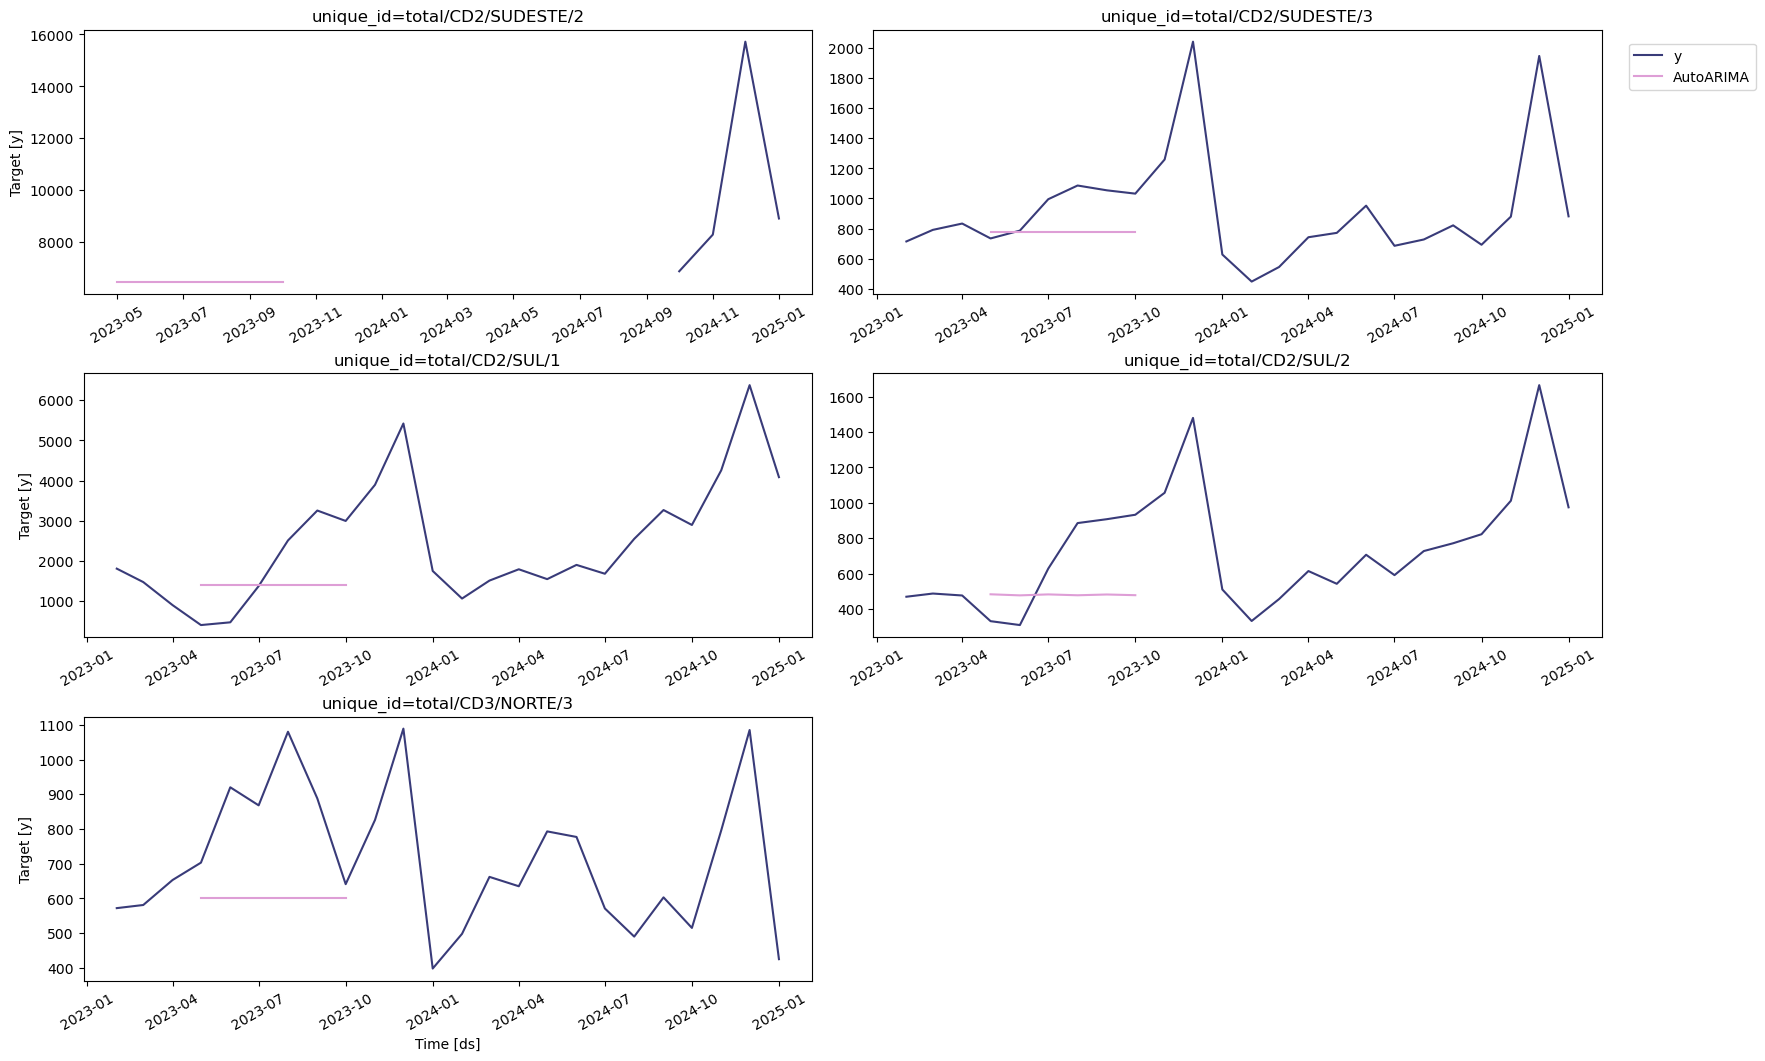

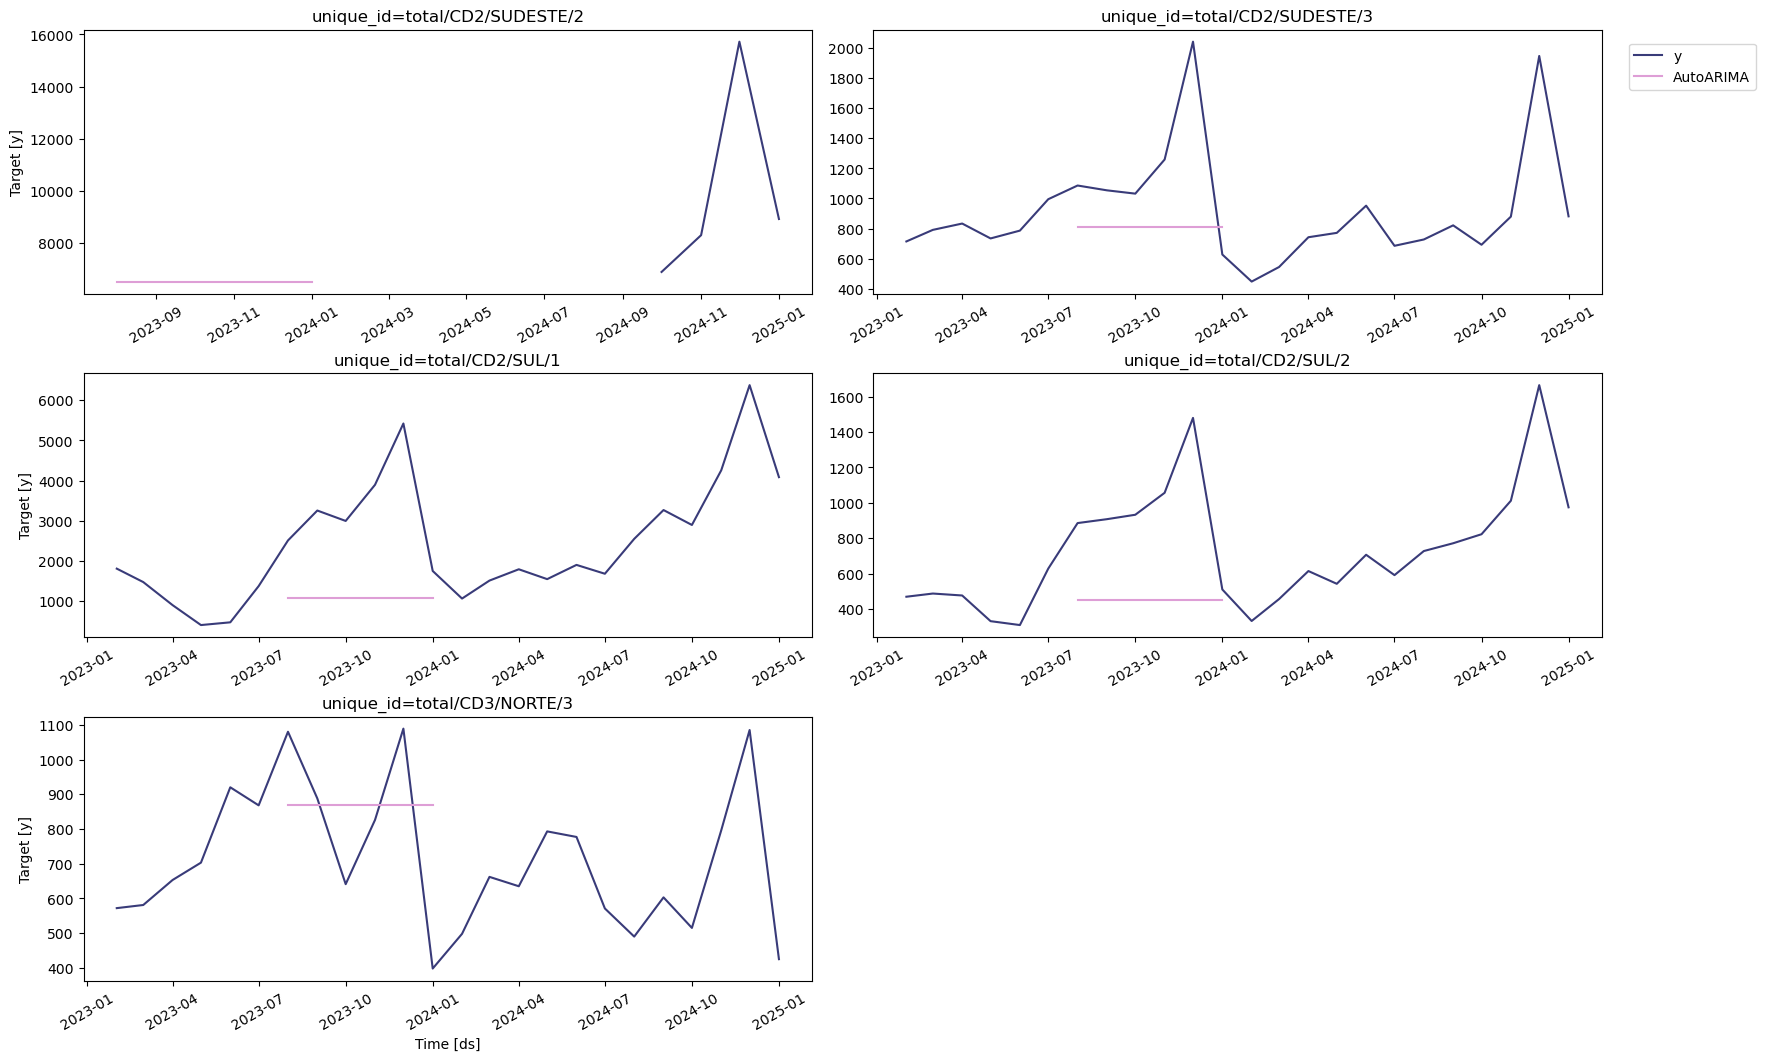

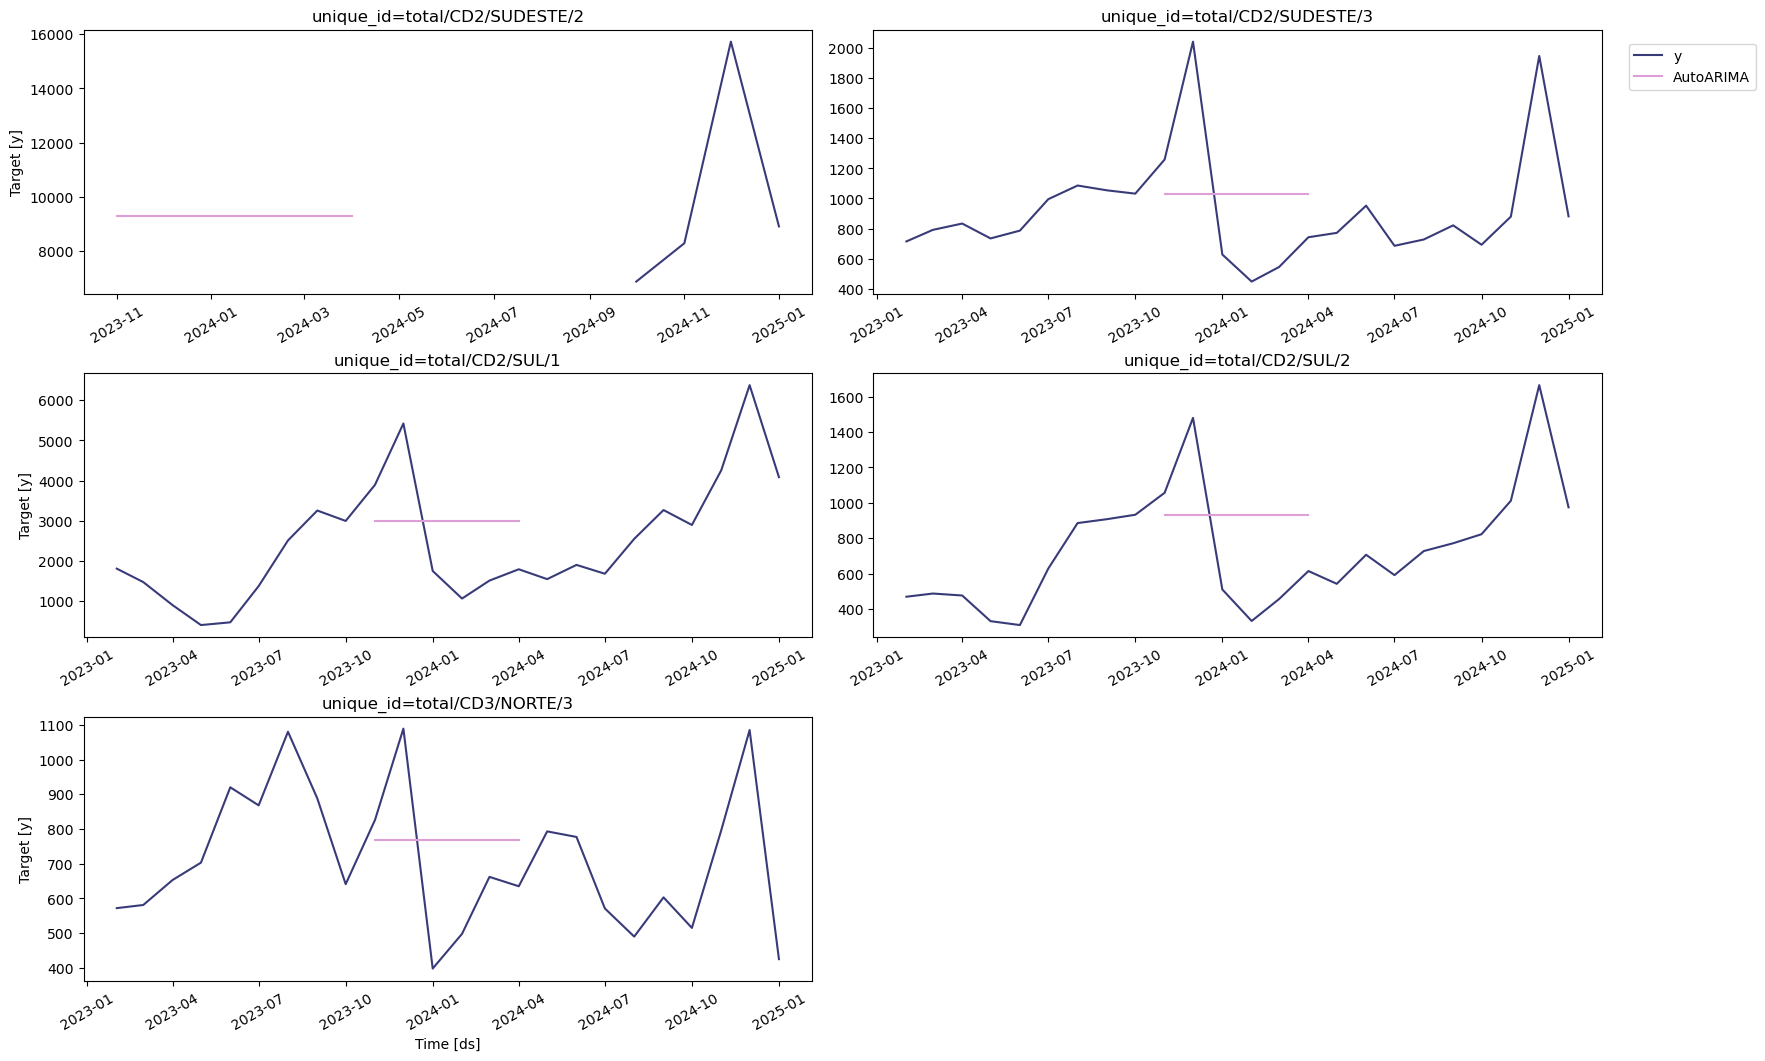

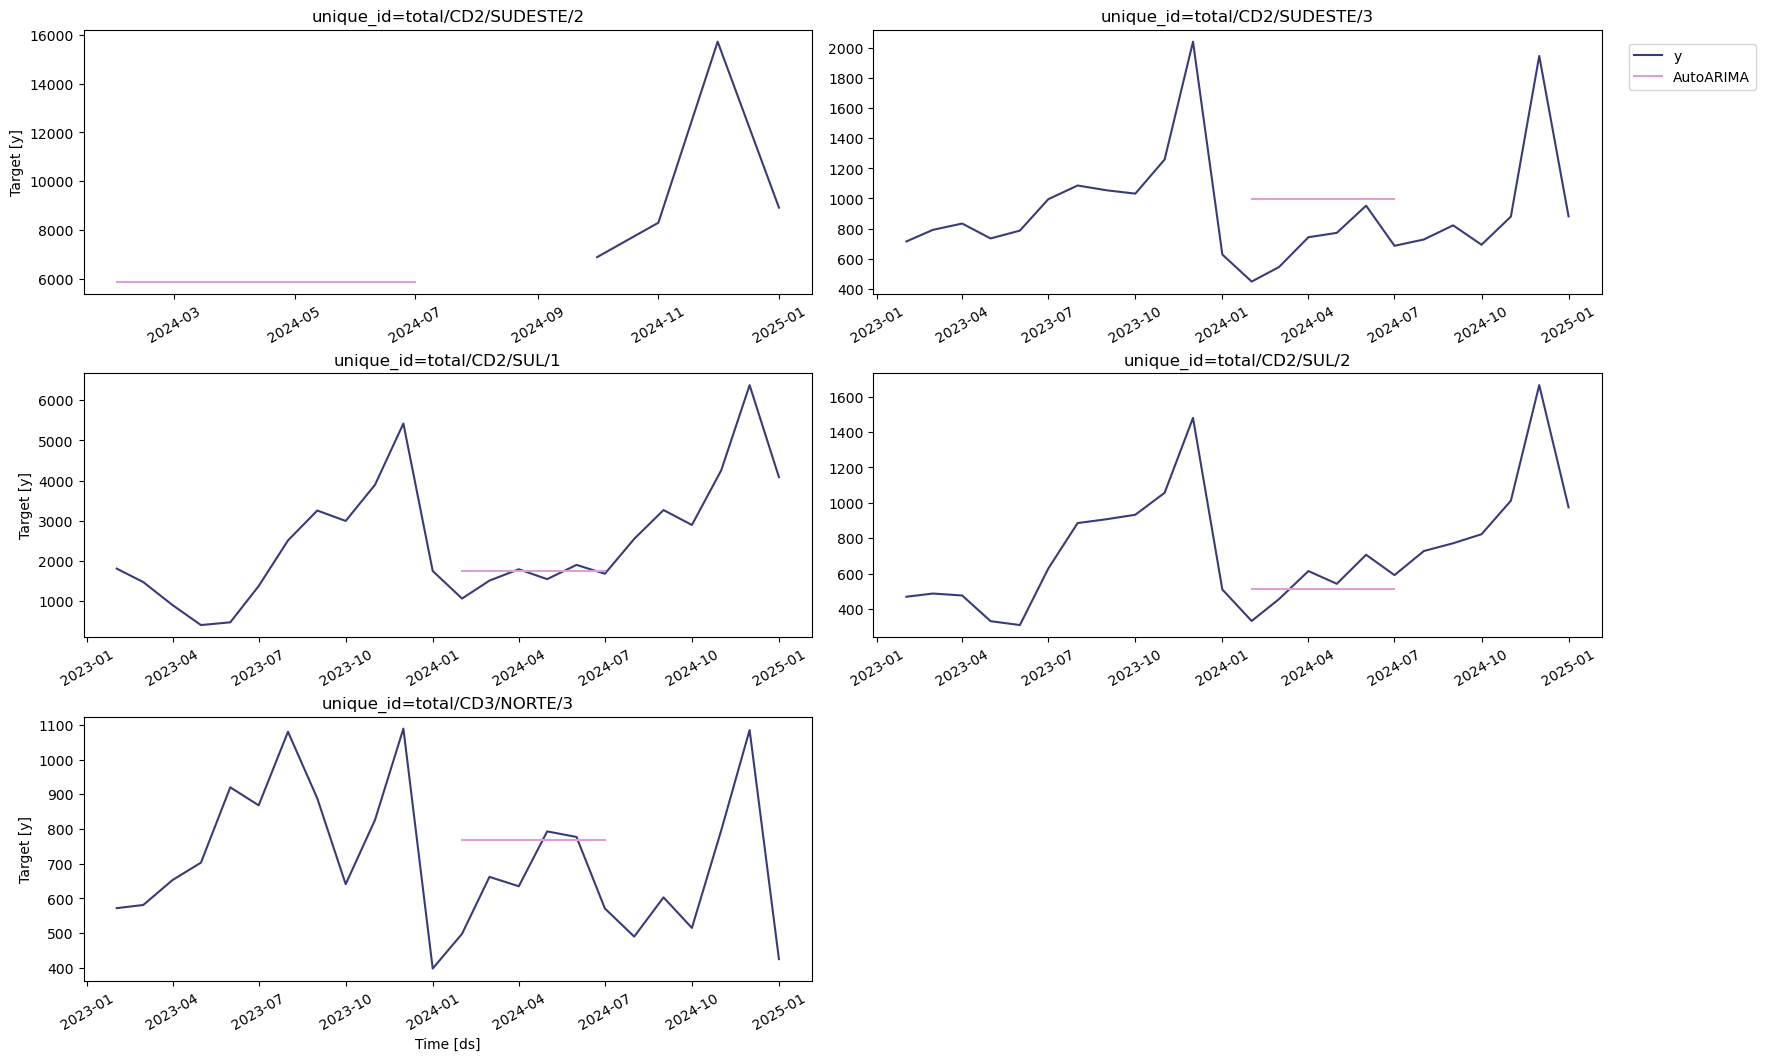

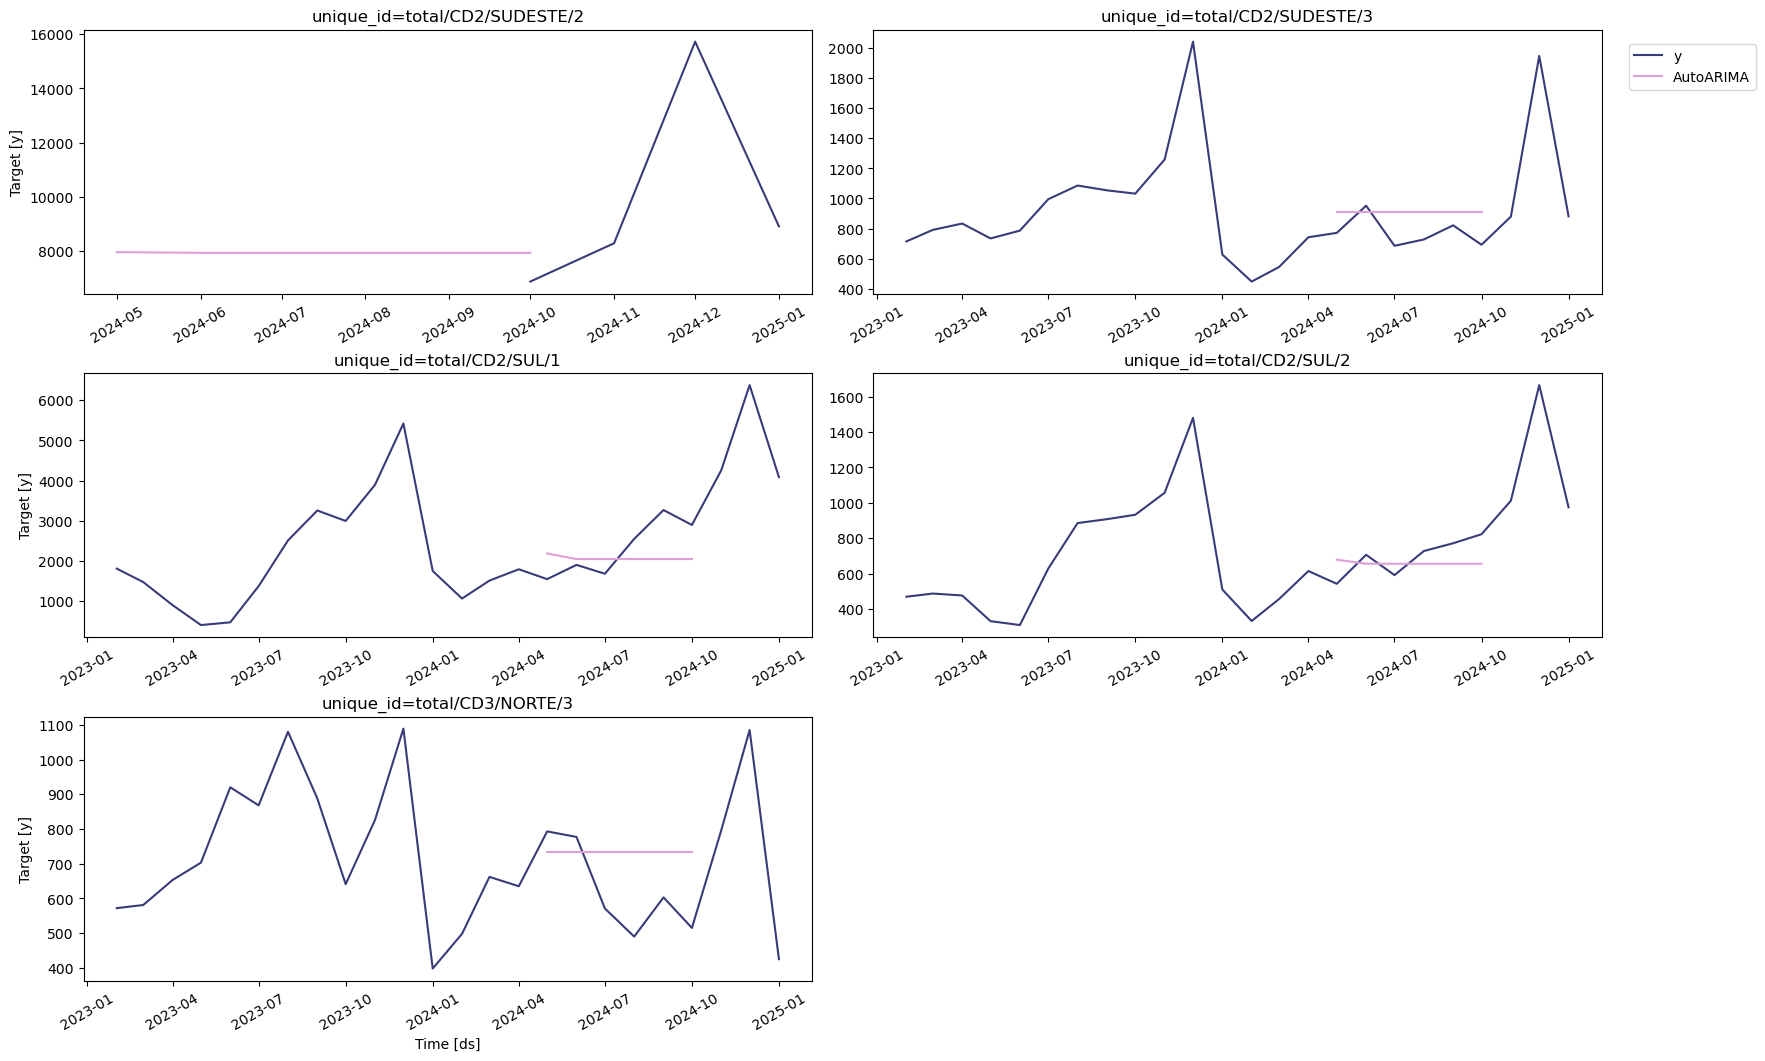

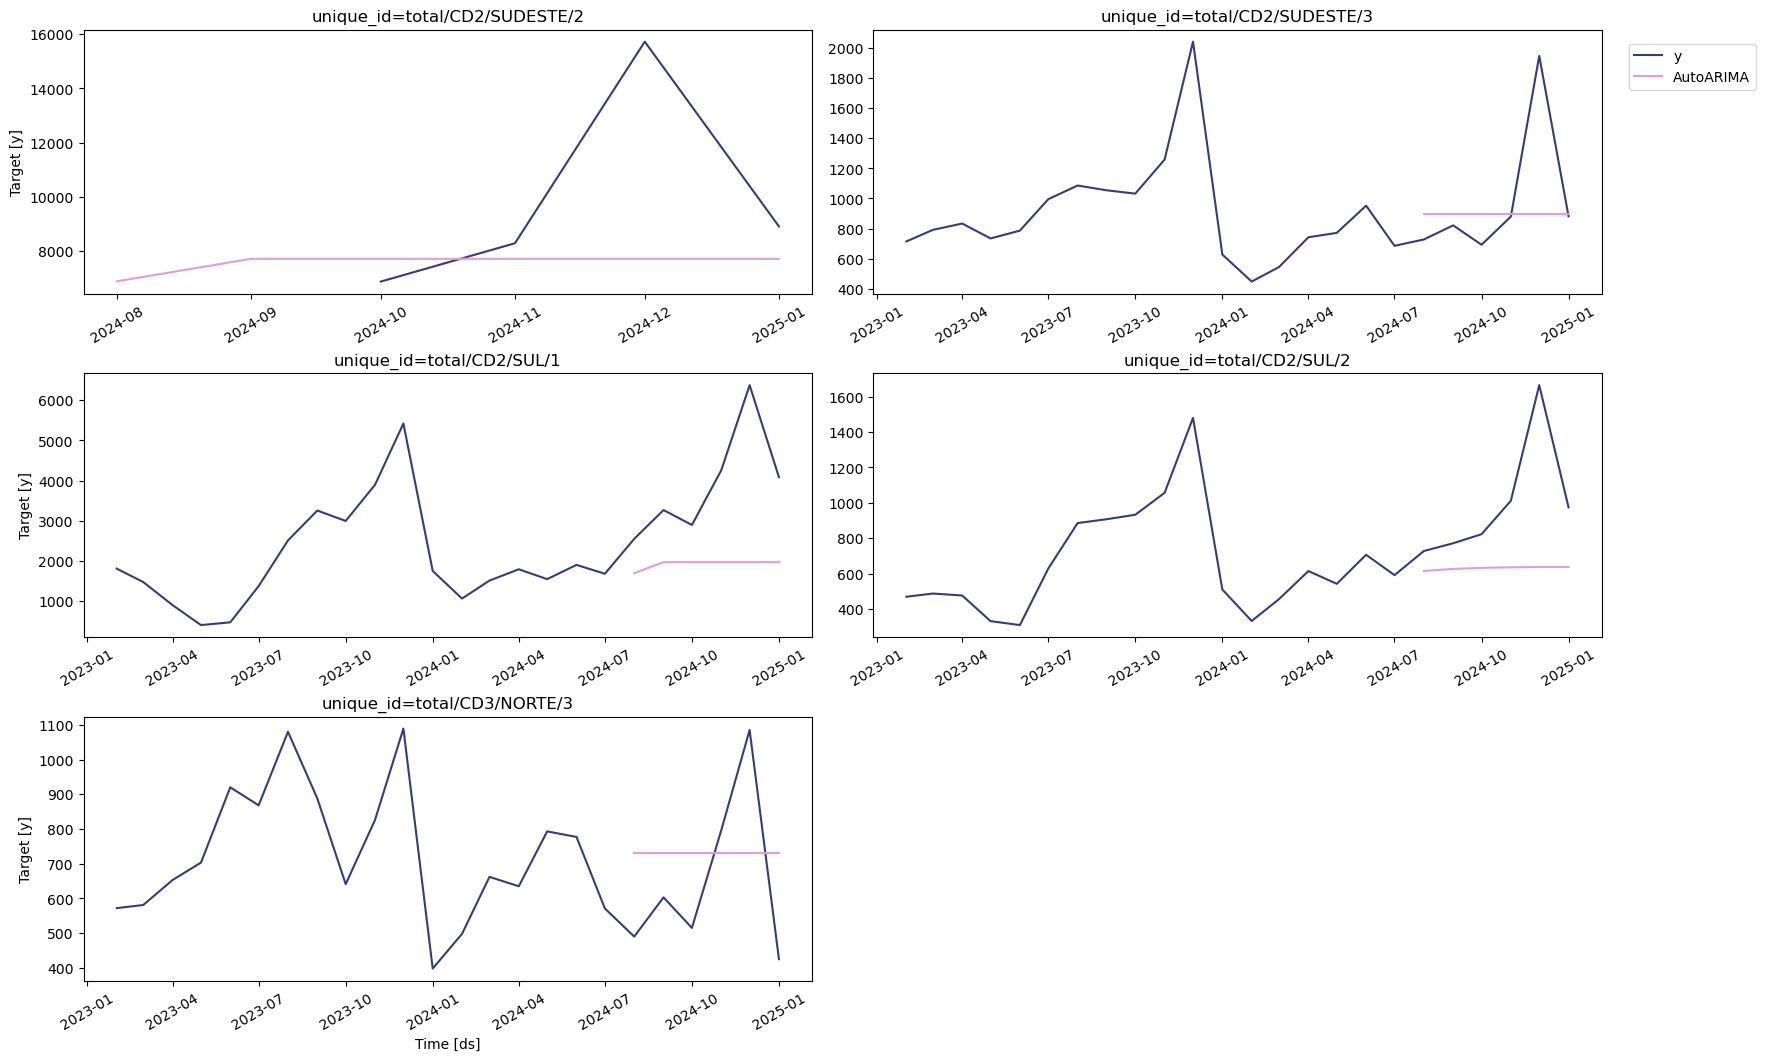

In [43]:
cutoffs = cv_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = sf.plot(
        Y_train_df.tail(100), 
        cv_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'y']),
        models=['AutoARIMA']
    )
    display(fig)

In [39]:
Y_train_df

,unique_id,ds,y
0,total,2023-02-01,21312.0
1,total,2023-03-01,21305.0
2,total,2023-04-01,21149.0
3,total,2023-05-01,19518.0
4,total,2023-06-01,22027.0
...,...,...,...
739,total/CD3/NORTE/3,2024-09-01,603.0
740,total/CD3/NORTE/3,2024-10-01,515.0
741,total/CD3/NORTE/3,2024-11-01,796.0
742,total/CD3/NORTE/3,2024-12-01,1085.0


In [21]:
Y_hat_df[Y_hat_df['unique_id']=='total']

,unique_id,ds,AutoARIMA
0,total,2025-02-01,25259.883952
1,total,2025-03-01,28369.601777
2,total,2025-04-01,28369.601777
3,total,2025-05-01,28369.601777
4,total,2025-06-01,28369.601777
5,total,2025-07-01,28369.601777


In [24]:
Y_hat_df

,unique_id,ds,AutoARIMA
0,total,2025-02-01,25259.883952
1,total,2025-03-01,28369.601777
2,total,2025-04-01,28369.601777
3,total,2025-05-01,28369.601777
4,total,2025-06-01,28369.601777
...,...,...,...
145,total/CD3/NORTE/3,2025-03-01,711.208333
146,total/CD3/NORTE/3,2025-04-01,711.208333
147,total/CD3/NORTE/3,2025-05-01,711.208333
148,total/CD3/NORTE/3,2025-06-01,711.208333


In [25]:
Y_hat_df[Y_hat_df['unique_id']=='total/CD3/NORTE/3']

,unique_id,ds,AutoARIMA
144,total/CD3/NORTE/3,2025-02-01,711.208333
145,total/CD3/NORTE/3,2025-03-01,711.208333
146,total/CD3/NORTE/3,2025-04-01,711.208333
147,total/CD3/NORTE/3,2025-05-01,711.208333
148,total/CD3/NORTE/3,2025-06-01,711.208333
149,total/CD3/NORTE/3,2025-07-01,711.208333


In [11]:
Y_fitted_df

,unique_id,ds,y,AutoARIMA
0,total,2023-02-01,21312.0,27890.604899
1,total,2023-03-01,21305.0,25941.680572
2,total,2023-04-01,21149.0,26577.919689
3,total,2023-05-01,19518.0,26262.119136
4,total,2023-06-01,22027.0,25750.035506
...,...,...,...,...
595,total/CD3/NORTE/3,2024-09-01,603.0,711.208333
596,total/CD3/NORTE/3,2024-10-01,515.0,711.208333
597,total/CD3/NORTE/3,2024-11-01,796.0,711.208333
598,total/CD3/NORTE/3,2024-12-01,1085.0,711.208333


In [60]:
Y_hat_df = sf.forecast(h=6, df=Y_train_df, fitted=True)
Y_fitted_df = sf.forecast_fitted_values()

In [62]:
Y_fitted_df

,unique_id,ds,y,AutoARIMA
0,total,2023-02-01,21312.0,27890.604899
1,total,2023-03-01,21305.0,25941.680572
2,total,2023-04-01,21149.0,26577.919689
3,total,2023-05-01,19518.0,26262.119136
4,total,2023-06-01,22027.0,25750.035506
...,...,...,...,...
91,total/CD3,2024-09-01,603.0,711.208333
92,total/CD3,2024-10-01,515.0,711.208333
93,total/CD3,2024-11-01,796.0,711.208333
94,total/CD3,2024-12-01,1085.0,711.208333


In [61]:
Y_hat_df

,unique_id,ds,AutoARIMA
0,total,2025-02-01,25259.883952
1,total,2025-03-01,28369.601777
2,total,2025-04-01,28369.601777
3,total,2025-05-01,28369.601777
4,total,2025-06-01,28369.601777
5,total,2025-07-01,28369.601777
6,total/CD1,2025-02-01,7384.291667
7,total/CD1,2025-03-01,7384.291667
8,total/CD1,2025-04-01,7384.291667
9,total/CD1,2025-05-01,7384.291667


In [194]:
# 4. Specify the reconcilers
reconcilers = [BottomUp(),TopDown(method='forecast_proportions'), MinTrace(method="ols"), MinTrace(method="mint_shrink")]

# 5. Reconcile the forecasts
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S_df=S_df, tags=tags)

In [180]:
from utilsforecast.plotting import plot_series

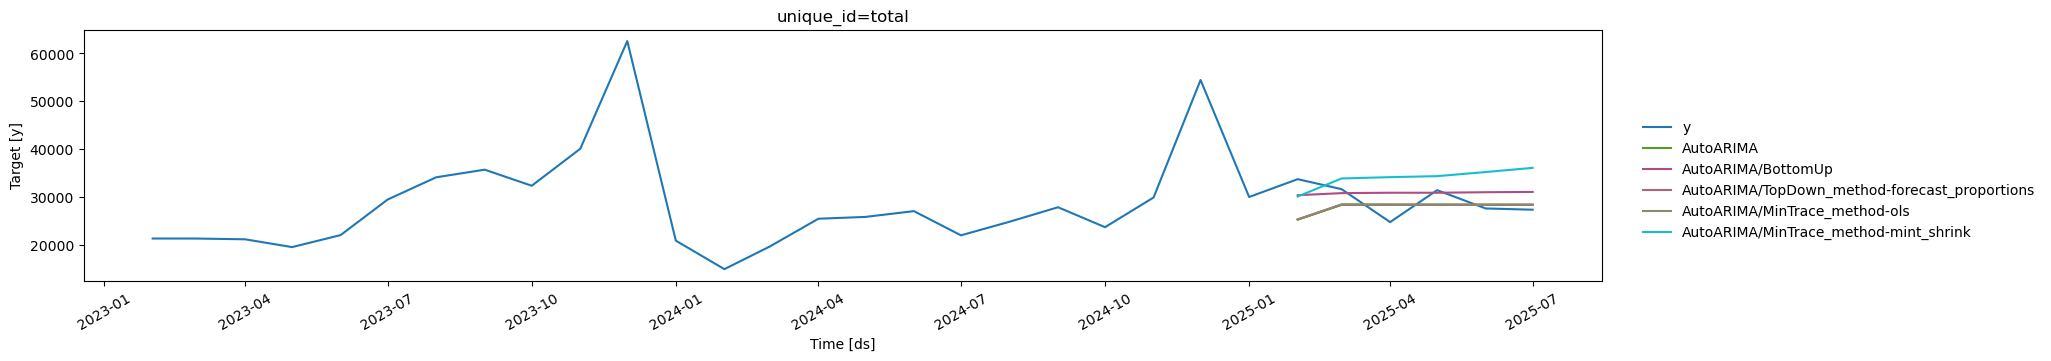

In [207]:
plot_aggs = list(tags["total"])

fig = plot_series(
    df=Y_df.query("unique_id in @plot_aggs"),
    forecasts_df=Y_rec_df.query("unique_id in @plot_aggs"),
    plot_random=False,
)
fig.legends = []
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5),
           borderaxespad=0,
           frameon=False)
fig

In [196]:
df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'], how='inner')

evaluate(df=df, metrics=[smape],
                   tags=tags)

,level,metric,AutoARIMA,AutoARIMA/BottomUp,AutoARIMA/TopDown_method-forecast_proportions,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-mint_shrink
0,total,smape,0.058243,0.051043,0.058243,0.058020,0.092386
1,total/centro_distribuicao,smape,0.107055,0.098622,0.107423,0.103665,0.112154
2,total/centro_distribuicao/regiao_loja,smape,0.118297,0.116900,0.122974,0.199944,0.117888
3,total/centro_distribuicao/regiao_loja/clima_loja,smape,0.108724,0.110116,0.113261,0.162459,0.123611
4,total/centro_distribuicao/regiao_loja/clima_lo...,smape,0.159310,0.151849,0.165165,0.166171,0.174827
5,total/centro_distribuicao/regiao_loja/clima_lo...,smape,0.233493,0.230107,0.238175,0.276249,0.262049
6,total/centro_distribuicao/regiao_loja/clima_lo...,smape,0.315006,0.312866,0.324447,0.354511,0.371548
7,total/centro_distribuicao/regiao_loja/clima_lo...,smape,0.490923,0.490923,0.500707,0.565616,0.578511
8,Overall,smape,0.443013,0.442347,0.452410,0.509073,0.521200


In [151]:
Y_rec_df

,unique_id,ds,AutoARIMA,AutoARIMA/BottomUp,AutoARIMA/TopDown_method-forecast_proportions,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-mint_shrink
0,total,2025-02-01,25259.883952,26703.961626,25259.883952,25294.608709,26437.444856
1,total,2025-03-01,28369.601777,29205.929621,28369.601777,28444.180529,29078.729157
2,total,2025-04-01,28369.601777,28944.670718,28369.601777,28419.616656,28853.955074
3,total,2025-05-01,28369.601777,28776.578592,28369.601777,28403.897618,28709.816450
4,total,2025-06-01,28369.601777,28667.969508,28369.601777,28393.824177,28617.151962
...,...,...,...,...,...,...,...
145,total/CD3/NORTE/3,2025-03-01,711.208333,711.208333,711.396456,686.348749,709.747727
146,total/CD3/NORTE/3,2025-04-01,711.208333,711.208333,711.396456,694.536707,710.215825
147,total/CD3/NORTE/3,2025-05-01,711.208333,711.208333,711.396456,699.776386,710.516237
148,total/CD3/NORTE/3,2025-06-01,711.208333,711.208333,711.396456,703.134200,710.709602


In [73]:
Y_test_df

,unique_id,ds,y
23,total,2025-01-01,29996.0
24,total,2025-02-01,33718.0
25,total,2025-03-01,31631.0
26,total,2025-04-01,24745.0
27,total,2025-05-01,31421.0
...,...,...,...
745,total/CD3/NORTE/3,2025-03-01,467.0
746,total/CD3/NORTE/3,2025-04-01,498.0
747,total/CD3/NORTE/3,2025-05-01,669.0
748,total/CD3/NORTE/3,2025-06-01,797.0
